In [1]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import time
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

# Optimizer
optimizer = tf.keras.optimizers.Adam(0.001)

#K-fold
k_fold = 4
k = k_fold
max_epoch = 100
# optimizer = tf.keras.optimizers.Adagrad(0.003)

In [2]:
rdkit.__version__

'2021.03.5'

In [3]:
dc.__version__

'2.5.0'

In [4]:
np.__version__

'1.19.5'

In [5]:
tf.__version__

'2.6.0'

In [6]:
# Loading molecular data
df = pd.read_csv('molecule_parameters.csv')
df.dropna(how='any', inplace=True)

In [7]:
# DDG Standard deviation
np.std(df.ddg)

2.697637870606162

In [8]:
# Normalizing entropy and add some noise
df['entropy'] = df['entropy'].astype(np.float) + np.random.normal(np.sqrt(df['entropy'].astype(np.float).mean()), 1, len(df))

In [9]:
training_columns = [col for col in df.columns if (col[:3] == 'gb-' and not col.__contains__('etot')) or (col.__contains__('vdwaals'))]

In [10]:
training_columns

['gb-complex-1-4-eel',
 'gb-complex-eelec',
 'gb-complex-egb',
 'gb-complex-esurf',
 'gb-protein-1-4-eel',
 'gb-protein-eelect',
 'gb-protein-egb',
 'gb-protein-esurf',
 'gb-ligand-1-4-eel',
 'gb-ligand-eelec',
 'gb-ligand-egb',
 'gb-ligand-esurf',
 'pb-complex-vdwaals',
 'pb-protein-vdwaals',
 'pb-ligand-vdwaals']

In [11]:
df['gb-overall-1-4-eel'] = df.apply(lambda row: row['gb-complex-1-4-eel'] - row['gb-protein-1-4-eel'] - row['gb-ligand-1-4-eel'], axis=1)
df['gb-overall-eelec'] = df.apply(lambda row: row['gb-complex-eelec'] - row['gb-protein-eelect'] - row['gb-ligand-eelec'], axis=1)
df['gb-overall-egb'] = df.apply(lambda row: row['gb-complex-egb'] - row['gb-protein-egb'] - row['gb-ligand-egb'], axis=1)
df['gb-overall-esurf'] = df.apply(lambda row: row['gb-complex-esurf'] - row['gb-protein-esurf'] - row['gb-ligand-esurf'], axis=1)
df['pb-overall-vdwaals'] = df.apply(lambda row: row['pb-complex-vdwaals'] - row['pb-protein-vdwaals'] - row['pb-ligand-vdwaals'], axis=1)

In [12]:
training_columns = [f for f in df.columns if f.__contains__('overall')]

In [13]:
training_columns

['gb-overall-1-4-eel',
 'gb-overall-eelec',
 'gb-overall-egb',
 'gb-overall-esurf',
 'pb-overall-vdwaals']

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[training_columns]),
                   columns=training_columns)

# Reading PDB files

In [15]:
# start time
start = time.time()
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
# mypath = '../../../../../../Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/pdbbind/raw-data/'
mypath = '../dataset-small/'
onlyfiles = [f for f in listdir(mypath) if f not in ('.DS_Store') and f in (df['complex-name'].tolist())]
for f in onlyfiles:
    print(f)
    PDBs.update({f: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + f + '/com_new.pqr')})

for key, value in dict(PDBs).items():
    if value is None:
        del PDBs[key]
time.sleep(1)
# end time
end = time.time()
# total time taken
print(f"PDB file reading runtime is {(end - start)/60} minutes")

1a1e
1a4r
1add
1a99
1a30
1a4w
1a4k
1aaq
1a9m
1a94
1a69
PDB file reading runtime is 1.1369648178418477 minutes


In [16]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

# Models

<h3>PGNNA model </h3>

In [17]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
# batch_size = int(len(pdb_names_train)/4)
# batch_size
# batch_size=10

In [18]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import sys
import tensorflow as tf
import random


class PGNNA(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
    
  def __init__(self, batch_size):
    super(PGNNA, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(64, activation=tf.nn.sigmoid)
    self.dense3 = layers.Dense(1)
    
    ## Dense for overall
    self.dense4 = layers.Dense(1, 
     kernel_initializer=initializers.Constant([.5, 1, 1, 1, 1, 1]),
     bias_initializer=initializers.Zeros())
#     self.dense4 = layers.Dense(1, 
#          kernel_initializer=initializers.Constant([.5, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]),
#          bias_initializer=initializers.Zeros(), activation=tf.keras.activations.relu)

  def call(self, inputs):
#     x_feat, x_add = inputs[0], inputs[1]
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 5])

    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    model_var = self.dense3(model_var)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    ddg = self.dense4(binding_affinity)
    tf.print(self.dense4.weights, output_stream="file://weights.txt", summarize=30)
    tf.print(binding_affinity[0], output_stream="file://binding_a.txt", summarize=30)
    tf.print(ddg[0], output_stream="file://ddg.txt")
    tf.print(model_var, output_stream="file://model_var.txt", summarize=30)
    tf.print("-------------------------", output_stream=sys.stdout)
    return ddg

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
# PGNNA_model = PGNNA(train_split_index)
# PGNNA_model.compile(optimizer = "adam", loss = root_mean_squared_error)
# K.set_value(PGNNA_model.optimizer.learning_rate, 0.001)

<h3> DDA</h3>

In [19]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import sys
import tensorflow as tf
import random


class DDA(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
    
  def __init__(self, batch_size):
    super(DDA, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(64, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(128, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(64, activation=tf.nn.sigmoid)
    self.dense3 = layers.Dense(1)
    
    ## Dense for overall
    self.dense4 = layers.Dense(1) 
#      kernel_initializer=initializers.Constant([.5, 1, 1, 1, 1, 1]),
#      bias_initializer=initializers.Zeros())
#     self.dense4 = layers.Dense(1, 
#          kernel_initializer=initializers.Constant([.5, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]),
#          bias_initializer=initializers.Zeros(), activation=tf.keras.activations.relu)

  def call(self, inputs):
#     x_feat, x_add = inputs[0], inputs[1]
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 5])

    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    model_var = self.dense3(model_var)
#     binding_affinity = tf.concat([model_var, x_add], axis=1)
#     ddg = self.dense4(binding_affinity)
#     tf.print(self.dense4.weights, output_stream="file://weights.txt", summarize=30)
#     tf.print(binding_affinity[0], output_stream="file://binding_a.txt", summarize=30)
#     tf.print(ddg[0], output_stream="file://ddg.txt")
#     tf.print(model_var, output_stream="file://model_var.txt", summarize=30)
#     tf.print("-------------------------", output_stream=sys.stdout)
    return model_var

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
# DDA_model = DDA(train_split_index)
# DDA_model.compile(optimizer = "adam", loss = root_mean_squared_error)
# K.set_value(DDA_model.optimizer.learning_rate, 0.001)

In [20]:
k

4

# K-fold

In [21]:
import warnings
warnings.filterwarnings('ignore')

TRAIN_SET_PERCENTAGE = 1-(1/k)
VAL_SET_PERCENTAGE = 1/k
PDBs.pop('',None)

# PGNNA model variables
PGNNA_train_losses = [[] for _ in range(k_fold)]
PGNNA_val_losses = [[] for _ in range(k_fold)]
PGNNA_rmse_train, PGNNA_rmse_test = [], []

# DDA model variables
DDA_train_losses = [[] for _ in range(k_fold)]
DDA_val_losses = [[] for _ in range(k_fold)]
DDA_rmse_train, DDA_rmse_test = [], []

# Defining Featurizer
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

# start time
start = time.time()


# k-fold loop
for fold in range(k_fold):
    # fold=0 -> 0 * (0.25 * 72) = 0
    # fold=1 -> 1 * (0.25 * 72) = 18
    # fold=2 -> 2 * (0.25 * 72) = 36
    # fold=3 -> 3 * (0.25 *72) = 54
    X, X_ids, pdb_names_val, pdb_names_test = [], [], [], []
    pdb_names_train, X_val_featurized, X_test_featurized, X_train_featurized  = [], [], [], []
    

    # Featurize PDB's
    for i in PDBs.keys():
        X_ids.append(i)
        X.append(featurizer.featurize(PDBs[i]))

    pdb_names = [i.split('-')[0] for i in X_ids]  
    TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)
    val_split_index_begin = int(fold * TEST_SIZE)
#     print(f"begin {val_split_index_begin}")
    val_split_index_end = int(val_split_index_begin) + int(TEST_SIZE)
#     print(f"end {val_split_index_end}")

    # validation
    pdb_names_val = pdb_names[val_split_index_begin:val_split_index_end]

    # Test set
    pdb_names_test = pdb_names[val_split_index_begin:val_split_index_end]
    
    # Train set
    pdb_names_train = [pdb_names[i] for i in range(len(pdb_names)) if i not in range(val_split_index_begin,val_split_index_end)]


    X = [x[0] for x in X]
    
    X_val_featurized = X[val_split_index_begin : val_split_index_end]
    X_test_featurized = X[val_split_index_begin : val_split_index_end]
    X_train_featurized = [X[i] for i in range(len(X)) if i not in range(val_split_index_begin, val_split_index_end)]
    
    ### Step
    
    x_add_train,x_add_val, x_add_test, y_train,y_val, y_test = [], [], [], [], [], []
    # Train
    for i in range(len(pdb_names_train)):
        new_df = df[(df['complex-name'] == pdb_names_train[i])]
        y_train.append(new_df['ddg'].to_numpy()[0])
        x_add_train.append(-new_df[training_columns].to_numpy()[0])
    y_train = np.array(y_train)

    # Val
    for i in range(len(pdb_names_val)):
        new_df = df[(df['complex-name'] == pdb_names_val[i])]
        y_val.append(new_df['ddg'].to_numpy()[0])
        x_add_val.append(-new_df[training_columns].to_numpy()[0])
    y_val = np.array(y_val)


    # Test
    for i in range(len(pdb_names_test)):
        new_df = df[(df['complex-name'] == pdb_names_test[i])]
    #     print(pdb_names_test[i])
    #     print(new_df['ddg'].to_numpy())
        y_test.append(new_df['ddg'].to_numpy()[0])
        x_add_test.append(-new_df[training_columns].to_numpy()[0])
    y_test = np.array(y_test)
    
    
    x_preprocessed_train, x_preprocessed_test = [], []

    ## for X train
    multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
    x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_train.append(np.array(x_add_train))

    ## for X val
    multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
    x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_val.append(np.array(x_add_val))

    ## for X test
    multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
    x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_test.append(np.array(x_add_test))
    
    ### Step
    
    # Training
    x_train = np.full([14, np.max([v.shape[0] for v in x_preprocessed_train]),
                      np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_train):
        if len(j.shape) > 1:
            x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_train = x_train.reshape([1] + list(x_train.shape))

    # Validation
    x_val = np.full([14, np.max([v.shape[0] for v in x_preprocessed_val]),
                      np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_val):
        if len(j.shape) > 1:
            x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_val = x_val.reshape([1] + list(x_val.shape))

    # Testing

    x_test = np.full([14, np.max([v.shape[0] for v in x_preprocessed_test]),
                      np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_test):
        if len(j.shape) > 1:
            x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_test = x_test.reshape([1] + list(x_test.shape))
    
    # Variable initializations for models
    
    val_size = len(y_val)
    train_size = len(y_train)
    
    # PGNNA Model
    batch_size = len(pdb_names_train)
    PGNNA_model = PGNNA(len(y_train))
    PGNNA_model.compile(optimizer = "adam", loss = root_mean_squared_error)
    K.set_value(PGNNA_model.optimizer.learning_rate, 0.001)
    print(f'PGNNA Model Fold # {fold}')
    for epoch in range(max_epoch):
        PGNNA_model.modify_graphgather(train_size)
        PGNNA_model.input_shapes = [i.shape for i in x_preprocessed_train]
        PGNNloss = PGNNA_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        PGNNA_train_losses[fold].append(PGNNloss.history['loss'][0])
        PGNNA_model.input_shapes = [i.shape for i in x_preprocessed_val]
        PGNNA_model.modify_graphgather(val_size)
        PGNNA_val_losses[fold].append(PGNNA_model.evaluate(x_val, y_val.reshape([1, -1])))
        
    PGNNA_model.input_shapes = [i.shape for i in x_preprocessed_test]
    PGNNA_model.modify_graphgather(len(y_test))
    evalu = PGNNA_model.evaluate(x_test, y_test.reshape([1, -1]))
    # PGNNA Testing RMSE calculation
    PGNNA_rmse_test.append(evalu)
    print(PGNNA_rmse_test)
    # PGNNA Training RMSE calculation
    PGNNA_train_loss = PGNNA_train_losses[fold][-1]
    PGNNA_rmse_train.append(PGNNA_train_loss)
    
    # Data Driven model
    DDA_model = DDA(len(y_train))
    DDA_model.compile(optimizer = "adam", loss = root_mean_squared_error)
    K.set_value(DDA_model.optimizer.learning_rate, 0.001)
    print(f'DDA Model Fold # {fold}')
    for epoch in range(max_epoch):
        DDA_model.modify_graphgather(train_size)
        DDA_model.input_shapes = [i.shape for i in x_preprocessed_train]
        DDAloss = DDA_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
        DDA_train_losses[fold].append(DDAloss.history['loss'][0])
        DDA_model.input_shapes = [i.shape for i in x_preprocessed_val]
        DDA_model.modify_graphgather(val_size)
        DDA_val_losses[fold].append(DDA_model.evaluate(x_val, y_val.reshape([1, -1])))
    
    DDA_model.input_shapes = [i.shape for i in x_preprocessed_test]
    DDA_model.modify_graphgather(len(y_test))
    DDA_evaluate = DDA_model.evaluate(x_test, y_test.reshape([1, -1]))
    # DDA Testing RMSE calculation
    DDA_rmse_test.append(DDA_evaluate)
    print(DDA_rmse_test)
    # DDA training RMSE calculation
    DDA_train_loss = DDA_train_losses[fold][-1]
    DDA_rmse_train.append(DDA_train_loss)
    
time.sleep(1)
# end time
end = time.time()
# total time taken
print(f"Model training and testing runtime is {(end - start)/60} minutes")

2022-04-02 22:17:58.068201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


PGNNA Model Fold # 0


2022-04-02 22:17:58.765476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


-------------------------
1/1 [==============================] - 14s 14s/step - loss: 83.2002
-------------------------
1/1 [==============================] - 2s 2s/step - loss: 35.3743
-------------------------
1/1 [==============================] - 0s 430ms/step - loss: 82.8952
-------------------------
1/1 [==============================] - 0s 211ms/step - loss: 35.4598
-------------------------
1/1 [==============================] - 0s 420ms/step - loss: 82.6375
-------------------------
1/1 [==============================] - 0s 231ms/step - loss: 35.6531
-------------------------
1/1 [==============================] - 0s 356ms/step - loss: 82.3601
-------------------------
1/1 [==============================] - 0s 199ms/step - loss: 35.7795
-------------------------
1/1 [==============================] - 0s 429ms/step - loss: 82.0961
-------------------------
1/1 [==============================] - 0s 198ms/step - loss: 35.9753
-------------------------
1/1 [=======================

1/1 [==============================] - 0s 413ms/step - loss: 74.9898
-------------------------
1/1 [==============================] - 0s 228ms/step - loss: 39.9111
-------------------------
1/1 [==============================] - 1s 579ms/step - loss: 74.8131
-------------------------
1/1 [==============================] - 0s 211ms/step - loss: 39.9960
-------------------------
1/1 [==============================] - 0s 420ms/step - loss: 74.6414
-------------------------
1/1 [==============================] - 0s 231ms/step - loss: 40.0894
-------------------------
1/1 [==============================] - 0s 384ms/step - loss: 74.4652
-------------------------
1/1 [==============================] - 0s 250ms/step - loss: 40.1352
-------------------------
1/1 [==============================] - 0s 378ms/step - loss: 74.2939
-------------------------
1/1 [==============================] - 0s 184ms/step - loss: 40.1404
-------------------------
1/1 [==============================] - 1s 622ms/st

1/1 [==============================] - 0s 404ms/step - loss: 67.4569
-------------------------
1/1 [==============================] - 0s 204ms/step - loss: 41.5251
-------------------------
1/1 [==============================] - 0s 482ms/step - loss: 67.2951
-------------------------
1/1 [==============================] - 0s 243ms/step - loss: 41.4614
-------------------------
1/1 [==============================] - 1s 504ms/step - loss: 67.1355
-------------------------
1/1 [==============================] - 0s 231ms/step - loss: 41.4885
-------------------------
1/1 [==============================] - 0s 442ms/step - loss: 66.9639
-------------------------
1/1 [==============================] - 0s 204ms/step - loss: 41.4027
-------------------------
1/1 [==============================] - 0s 354ms/step - loss: 66.7946
-------------------------
1/1 [==============================] - 0s 159ms/step - loss: 41.2539
-------------------------
1/1 [==============================] - 0s 486ms/st

1/1 [==============================] - 1s 617ms/step - loss: 1.6661


1/1 [==============================] - 0s 232ms/step - loss: 2.1638
[2.163783073425293]
PGNNA Model Fold # 1
-------------------------
1/1 [==============================] - 8s 8s/step - loss: 69.3381
-------------------------
1/1 [==============================] - 2s 2s/step - loss: 103.5636
-------------------------
1/1 [==============================] - 1s 770ms/step - loss: 69.1195
-------------------------
1/1 [==============================] - 0s 85ms/step - loss: 103.3834
-------------------------
1/1 [==============================] - 1s 724ms/step - loss: 68.9187
-------------------------
1/1 [==============================] - 0s 56ms/step - loss: 103.2200
-------------------------
1/1 [==============================] - 1s 789ms/step - loss: 68.7257
-------------------------
1/1 [==============================] - 0s 59ms/step - loss: 102.9966
-------------------------
1/1 [==============================] - 1s 673ms/step - loss: 68.5571
-------------------------
1/1 [==========

1/1 [==============================] - 1s 691ms/step - loss: 62.9759
-------------------------
1/1 [==============================] - 0s 68ms/step - loss: 97.5692
-------------------------
1/1 [==============================] - 1s 649ms/step - loss: 62.8529
-------------------------
1/1 [==============================] - 0s 62ms/step - loss: 97.4339
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 62.6989
-------------------------
1/1 [==============================] - 0s 211ms/step - loss: 97.3157
-------------------------
1/1 [==============================] - 1s 882ms/step - loss: 62.5254
-------------------------
1/1 [==============================] - 0s 71ms/step - loss: 97.1924
-------------------------
1/1 [==============================] - 1s 692ms/step - loss: 62.3933
-------------------------
1/1 [==============================] - 0s 80ms/step - loss: 97.0761
-------------------------
1/1 [==============================] - 1s 767ms/step - lo

1/1 [==============================] - 0s 115ms/step - loss: 92.6153
-------------------------
1/1 [==============================] - 1s 725ms/step - loss: 56.7773
-------------------------
1/1 [==============================] - 0s 62ms/step - loss: 92.4242
-------------------------
1/1 [==============================] - 1s 939ms/step - loss: 56.6447
-------------------------
1/1 [==============================] - 0s 140ms/step - loss: 92.3816
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 56.5047
-------------------------
1/1 [==============================] - 0s 101ms/step - loss: 92.3014
-------------------------
1/1 [==============================] - 1s 878ms/step - loss: 56.3668
-------------------------
1/1 [==============================] - 0s 79ms/step - loss: 92.2922
-------------------------
1/1 [==============================] - 1s 758ms/step - loss: 56.2318
-------------------------
1/1 [==============================] - 0s 77ms/step - l

1/1 [==============================] - 0s 65ms/step - loss: 1.6335


1/1 [==============================] - 0s 69ms/step - loss: 1.6335
[2.163783073425293, 1.633509635925293]
PGNNA Model Fold # 2
-------------------------
1/1 [==============================] - 16s 16s/step - loss: 82.7971
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 38.8937
-------------------------
1/1 [==============================] - 1s 662ms/step - loss: 82.5513
-------------------------
1/1 [==============================] - 0s 70ms/step - loss: 39.9125
-------------------------
1/1 [==============================] - 1s 615ms/step - loss: 82.3075
-------------------------
1/1 [==============================] - 0s 78ms/step - loss: 40.9301
-------------------------
1/1 [==============================] - 1s 700ms/step - loss: 82.0616
-------------------------
1/1 [==============================] - 0s 110ms/step - loss: 41.9553
-------------------------
1/1 [==============================] - 1s 826ms/step - loss: 81.8276
------------------------

1/1 [==============================] - 0s 105ms/step - loss: 70.9838
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 75.3650
-------------------------
1/1 [==============================] - 0s 224ms/step - loss: 71.2822
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 75.2157
-------------------------
1/1 [==============================] - 0s 159ms/step - loss: 71.5536
-------------------------
1/1 [==============================] - 1s 597ms/step - loss: 75.0729
-------------------------
1/1 [==============================] - 0s 102ms/step - loss: 71.7300
-------------------------
1/1 [==============================] - 1s 679ms/step - loss: 74.9334
-------------------------
1/1 [==============================] - 0s 136ms/step - loss: 71.9223
-------------------------
1/1 [==============================] - 1s 715ms/step - loss: 74.7910
-------------------------
1/1 [==============================] - 0s 131ms/step - l

1/1 [==============================] - 0s 166ms/step - loss: 69.8878
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 69.2723
-------------------------
1/1 [==============================] - 0s 148ms/step - loss: 69.6613
-------------------------
1/1 [==============================] - 1s 840ms/step - loss: 69.1427
-------------------------
1/1 [==============================] - 0s 154ms/step - loss: 69.5780
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 69.0135
-------------------------
1/1 [==============================] - 0s 146ms/step - loss: 69.4015
-------------------------
1/1 [==============================] - 1s 660ms/step - loss: 68.8808
-------------------------
1/1 [==============================] - 0s 161ms/step - loss: 69.1539
-------------------------
1/1 [==============================] - 1s 720ms/step - loss: 68.7471
-------------------------
1/1 [==============================] - 0s 79ms/step - lo

1/1 [==============================] - 1s 842ms/step - loss: 1.7796


1/1 [==============================] - 0s 139ms/step - loss: 0.5318
[2.163783073425293, 1.633509635925293, 0.5317752361297607]
PGNNA Model Fold # 3
-------------------------
1/1 [==============================] - 8s 8s/step - loss: 77.3681
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 74.7282
-------------------------
1/1 [==============================] - 1s 768ms/step - loss: 77.1607
-------------------------
1/1 [==============================] - 0s 50ms/step - loss: 74.4761
-------------------------
1/1 [==============================] - 1s 708ms/step - loss: 76.9616
-------------------------
1/1 [==============================] - 0s 57ms/step - loss: 74.2063
-------------------------
1/1 [==============================] - 1s 678ms/step - loss: 76.7965
-------------------------
1/1 [==============================] - 0s 56ms/step - loss: 73.9913
-------------------------
1/1 [==============================] - 1s 744ms/step - loss: 76.6055
------

1/1 [==============================] - 1s 719ms/step - loss: 71.2668
-------------------------
1/1 [==============================] - 0s 72ms/step - loss: 66.2353
-------------------------
1/1 [==============================] - 1s 719ms/step - loss: 71.1264
-------------------------
1/1 [==============================] - 0s 69ms/step - loss: 66.1277
-------------------------
1/1 [==============================] - 1s 880ms/step - loss: 70.9774
-------------------------
1/1 [==============================] - 0s 78ms/step - loss: 66.0221
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 70.8483
-------------------------
1/1 [==============================] - 0s 63ms/step - loss: 65.8276
-------------------------
1/1 [==============================] - 1s 1s/step - loss: 70.7079
-------------------------
1/1 [==============================] - 0s 84ms/step - loss: 65.5834
-------------------------
1/1 [==============================] - 1s 918ms/step - loss: 

1/1 [==============================] - 0s 59ms/step - loss: 59.9041
-------------------------
1/1 [==============================] - 1s 930ms/step - loss: 65.2039
-------------------------
1/1 [==============================] - 0s 56ms/step - loss: 59.6996
-------------------------
1/1 [==============================] - 1s 608ms/step - loss: 65.0723
-------------------------
1/1 [==============================] - 0s 49ms/step - loss: 59.5626
-------------------------
1/1 [==============================] - 1s 581ms/step - loss: 64.9429
-------------------------
1/1 [==============================] - 0s 50ms/step - loss: 59.2020
-------------------------
1/1 [==============================] - 1s 570ms/step - loss: 64.8168
-------------------------
1/1 [==============================] - 0s 49ms/step - loss: 59.0541
-------------------------
1/1 [==============================] - 1s 573ms/step - loss: 64.6915
-------------------------
1/1 [==============================] - 0s 49ms/step - l

1/1 [==============================] - 1s 727ms/step - loss: 1.7871


1/1 [==============================] - 0s 86ms/step - loss: 2.0686
[2.163783073425293, 1.633509635925293, 0.5317752361297607, 2.068578004837036]
Model training and testing runtime is 18.266829534371695 minutes


In [28]:
# chekcing the wights after training PGNNA MODEL
PGNNA_model.layers[-1].get_weights()

[array([[0.6219718 ],
        [1.1000078 ],
        [0.89701515],
        [0.9082297 ],
        [1.08972   ],
        [1.0899081 ]], dtype=float32),
 array([0.09051859], dtype=float32)]

In [29]:
DDA_rmse_train

[1.6661344766616821, 1.967393159866333, 1.7795567512512207, 1.7871183156967163]

In [30]:
# calculating the average RMSE on Training set
average_DDA_rmse_train = sum(DDA_rmse_train) / len(DDA_rmse_train)
average_PGNNA_rmse_train = sum(PGNNA_rmse_train) / len(PGNNA_rmse_train)
# calculating the average RMSE on Testing set
average_DDA_rmse_test = sum(DDA_rmse_test) / len(DDA_rmse_test)
average_PGNNA_rmse_test = sum(PGNNA_rmse_test) / len(PGNNA_rmse_test)

# Model Performance Graphs

<h3>PGNNA Model </h3>

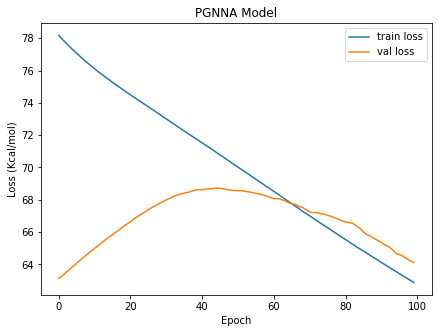

In [31]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_PGNNA_train_losses = [sum(x)/len(x) for x in zip(*PGNNA_train_losses)]
average_PGNNA_val_losses = [sum(x)/len(x) for x in zip(*PGNNA_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_PGNNA_train_losses)), average_PGNNA_train_losses, label='train loss')
plt.plot(range(len(average_PGNNA_val_losses)), average_PGNNA_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title("PGNNA Model")
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("PGNNA_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

<h3>DDA Model </h3>

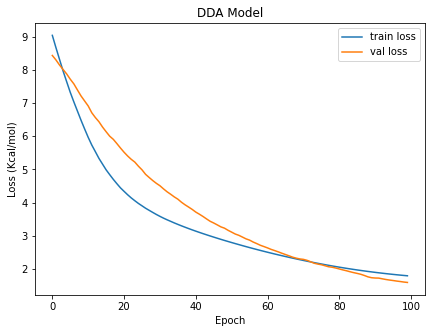

In [32]:
import matplotlib.pyplot as plt
# Calculating the average of k-fold losses
average_DDA_train_losses = [sum(x)/len(x) for x in zip(*DDA_train_losses)]
average_DDA_val_losses = [sum(x)/len(x) for x in zip(*DDA_val_losses)]
plt.figure(figsize=(7,5))
plt.plot(range(len(average_DDA_train_losses)), average_DDA_train_losses, label='train loss')
plt.plot(range(len(average_DDA_val_losses)), average_DDA_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
# plt.ylim(0,100)
plt.title('DDA Model')
# Time stamp with date and time
time.strftime("%Y-%m-%d %H%M%S")

# save plot
plt.savefig("DDA_loss" + time.strftime("%Y-%m-%d %H%M%S") + ".png")

# Comparison

In [33]:
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Models Comparison"
rmse_table.field_names = ["DDA (TRAIN)", "PGNNA (TRAIN)", "DDA (TEST)", "PGNNA (TEST)"]
rmse_table.add_row([ "{:.2f}".format(average_DDA_rmse_train),"{:.2f}".format(average_PGNNA_rmse_train),
                   "{:.2f}".format(average_DDA_rmse_test),"{:.2f}".format(average_PGNNA_rmse_test)])

print(rmse_table) 

+---------------------------------------------------------+
|                    Models Comparison                    |
+-------------+---------------+------------+--------------+
| DDA (TRAIN) | PGNNA (TRAIN) | DDA (TEST) | PGNNA (TEST) |
+-------------+---------------+------------+--------------+
|     1.80    |     62.88     |    1.60    |    64.13     |
+-------------+---------------+------------+--------------+
